In [2]:
from diffusers import AutoPipelineForImage2Image, StableDiffusionImg2ImgPipeline
from diffusers.utils import load_image, make_image_grid
import diffusers
import torch
from transformers import CLIPVisionModelWithProjection

pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(
    "stablediffusionapi/disney-pixar-cartoon", torch_dtype=torch.float16
).to("cuda")
pipeline.load_ip_adapter("h94/IP-Adapter", subfolder="models", weight_name="ip-adapter-plus-face_sd15.bin")

pipeline.scheduler = diffusers.EulerDiscreteScheduler.from_config(
    pipeline.scheduler.config
)

/home/danielko/miniconda3/envs/pixarsd/lib/python3.10/site-packages/diffusers/models/vq_model.py:20: FutureWarning: `VQEncoderOutput` is deprecated and will be removed in version 0.31. Importing `VQEncoderOutput` from `diffusers.models.vq_model` is deprecated and this will be removed in a future version. Please use `from diffusers.models.autoencoders.vq_model import VQEncoderOutput`, instead.
  deprecate("VQEncoderOutput", "0.31", deprecation_message)
/home/danielko/miniconda3/envs/pixarsd/lib/python3.10/site-packages/diffusers/models/vq_model.py:25: FutureWarning: `VQModel` is deprecated and will be removed in version 0.31. Importing `VQModel` from `diffusers.models.vq_model` is deprecated and this will be removed in a future version. Please use `from diffusers.models.autoencoders.vq_model import VQModel`, instead.
  deprecate("VQModel", "0.31", deprecation_message)
unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /mnt/data/.cache/huggingface/hub/models--stablediffusionapi--disney-pixar-cartoon/snapshots/ac09f29885253b7ed5b5aecc9c4fb053b528047a/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /mnt/data/.cache/huggingface/hub/models--stablediffusionapi--disney-pixar-cartoon/snapshots/ac09f29885253b7ed5b5aecc9c4fb053b528047a/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /mnt/data/.cache/huggingface/hub/models--stablediffusionapi--disney-pixar-cartoon/snapshots/ac09f29885253b7ed5b5aecc9c4fb053b528047a/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /mnt/data/.cache/huggingface/hub/models--stablediffusionapi--disney-pixar-cartoon/snapshots/ac09f29885253b7ed5b5aecc9c4fb053b528047a/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/home/danielko/miniconda3/envs/pixarsd

In [3]:
from PIL import Image
import math

def create_collage(images, size=(1024, 1024)):
    num_images = len(images)
    cols = math.ceil(math.sqrt(num_images))
    rows = math.ceil(num_images / cols)

    img_width = size[0] // cols
    img_height = size[1] // rows

    collage = Image.new('RGB', size)

    x_offset = 0
    y_offset = 0
    for i, img in enumerate(images):
        # Resize and crop the image to fit
        img_aspect = img.width / img.height
        cell_aspect = img_width / img_height
        if img_aspect > cell_aspect:
            new_width = int(img_height * img_aspect)
            img = img.resize((new_width, img_height), Image.LANCZOS)
            left = (new_width - img_width) // 2
            img = img.crop((left, 0, left + img_width, img_height))
        else:
            new_height = int(img_width / img_aspect)
            img = img.resize((img_width, new_height), Image.LANCZOS)
            top = (new_height - img_height) // 2
            img = img.crop((0, top, img_width, top + img_height))

        collage.paste(img, (x_offset, y_offset))
        x_offset += img_width
        if (i + 1) % cols == 0:
            x_offset = 0
            y_offset += img_height

    return collage

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/danielko/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/danielko/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/danielko/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/danielko/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/danielko/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

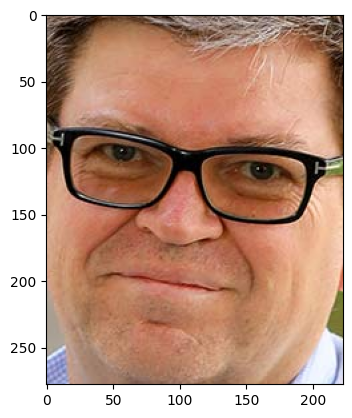

  0%|          | 0/30 [00:00<?, ?it/s]

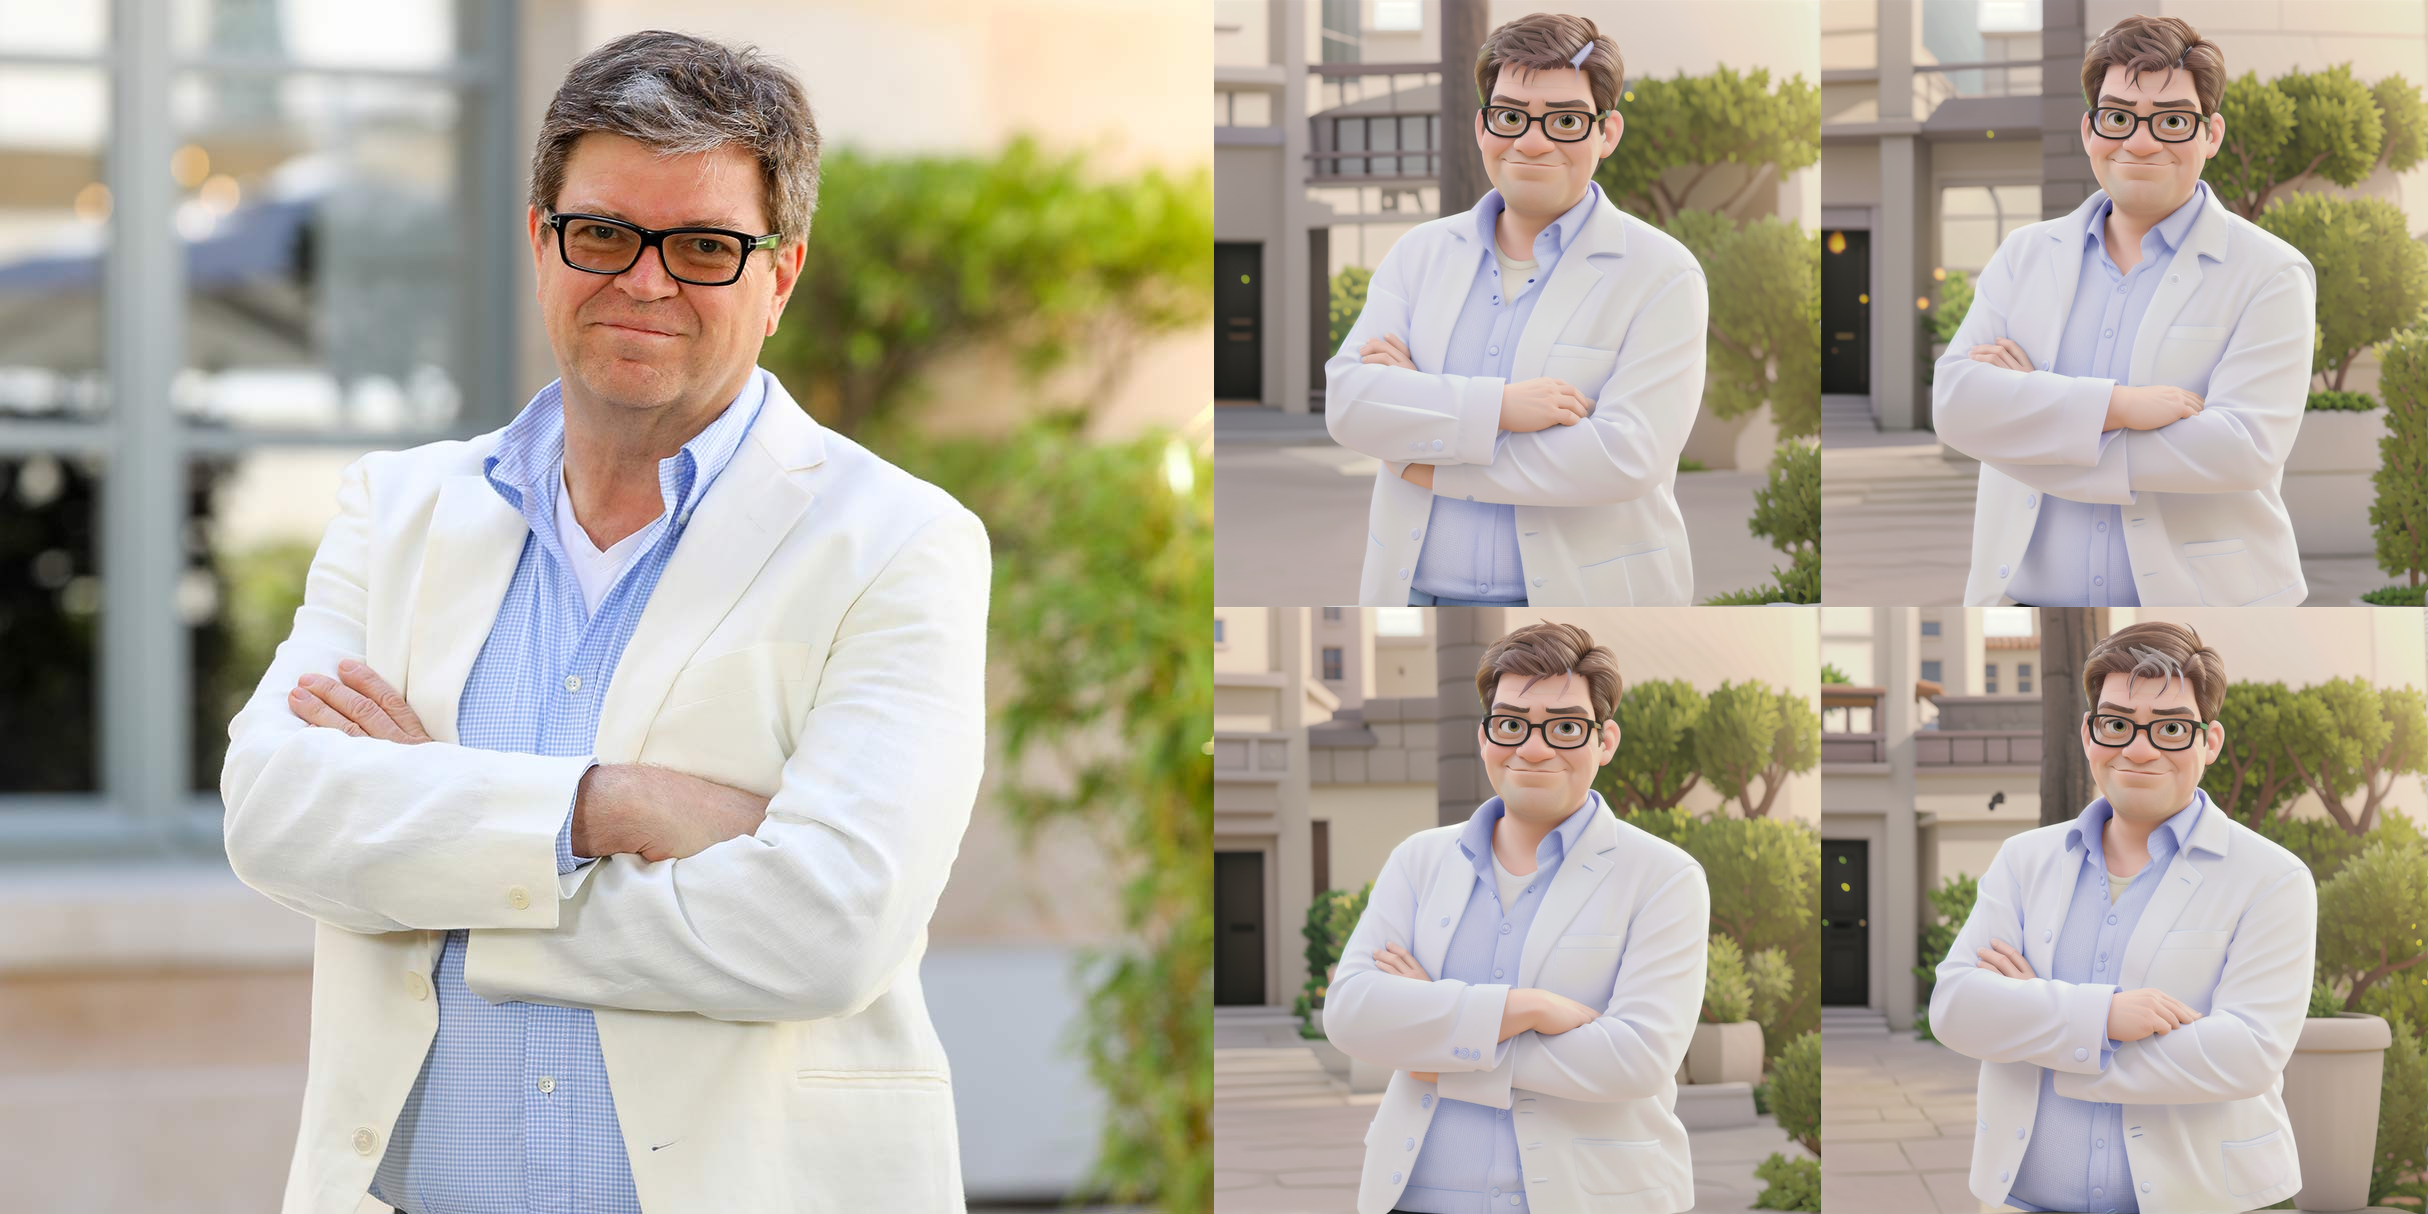

In [13]:
import cv2
from insightface.app import FaceAnalysis
import torch
import numpy as np
import matplotlib.pyplot as plt

app = FaceAnalysis(name="buffalo_l", providers=['CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

path_or_url = "https://www.adagiapartners.com/wp-content/uploads/2022/09/yann-lecun-web.jpg"
init_image = load_image(path_or_url)

faces = app.get(np.array(init_image))

faceid_embeds = torch.from_numpy(faces[0].normed_embedding).unsqueeze(0)

bbox = faces[0]['bbox']
cropped_image = np.array(init_image)[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
plt.imshow(cropped_image)
plt.show()

prompt = "breathtaking 3D image in the pixar style, disney, cartoon, 4k,unreal engine, blender 8k,outdoor,natural lighting,adult,clear face,stock image"
negative_prompt = "noisy, sloppy, messy, grainy, highly detailed, ultra textured, photo, NSFW"
H, W = 1024, 1024
n_infer_steps = 32
guidance_scale = 10.5
prompt_strength = 0.6
high_noise_frac = 0.8
num_images_per_prompt = 4

ip_adapter_scale = 0.8

pipeline.set_ip_adapter_scale(ip_adapter_scale)

images = pipeline(prompt, 
                 negative_prompt=negative_prompt, 
                 image=init_image, 
                 strength=prompt_strength, 
                 guidance_scale=guidance_scale,
                 num_inference_steps=n_infer_steps,
                 num_images_per_prompt=num_images_per_prompt,
                 target_size = (H, W),
                 ip_adapter_image=cropped_image,
                 clip_skip=1,
                 high_noise_frac=high_noise_frac)

image = create_collage(images.images, init_image.size)

make_image_grid([init_image, image], rows=1, cols=2)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/danielko/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0


2024-07-22 18:52:20.644260825 [E:onnxruntime:Default, provider_bridge_ort.cc:1745 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1426 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory

2024-07-22 18:52:21.032499746 [E:onnxruntime:Default, provider_bridge_ort.cc:1745 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1426 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory



Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/danielko/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/danielko/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/danielko/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0


2024-07-22 18:52:21.053545268 [E:onnxruntime:Default, provider_bridge_ort.cc:1745 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1426 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory

2024-07-22 18:52:21.081802759 [E:onnxruntime:Default, provider_bridge_ort.cc:1745 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1426 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory

2024-07-22 18:52:21.172873323 [E:onnxruntime:Default, provider_bridge_ort.cc:1745 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/danielko/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


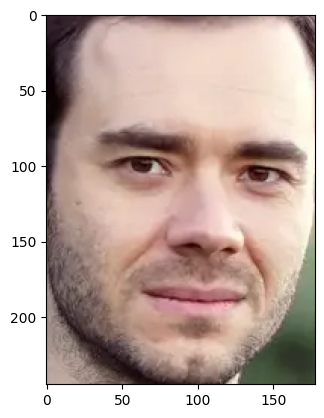

  0%|          | 0/19 [00:00<?, ?it/s]

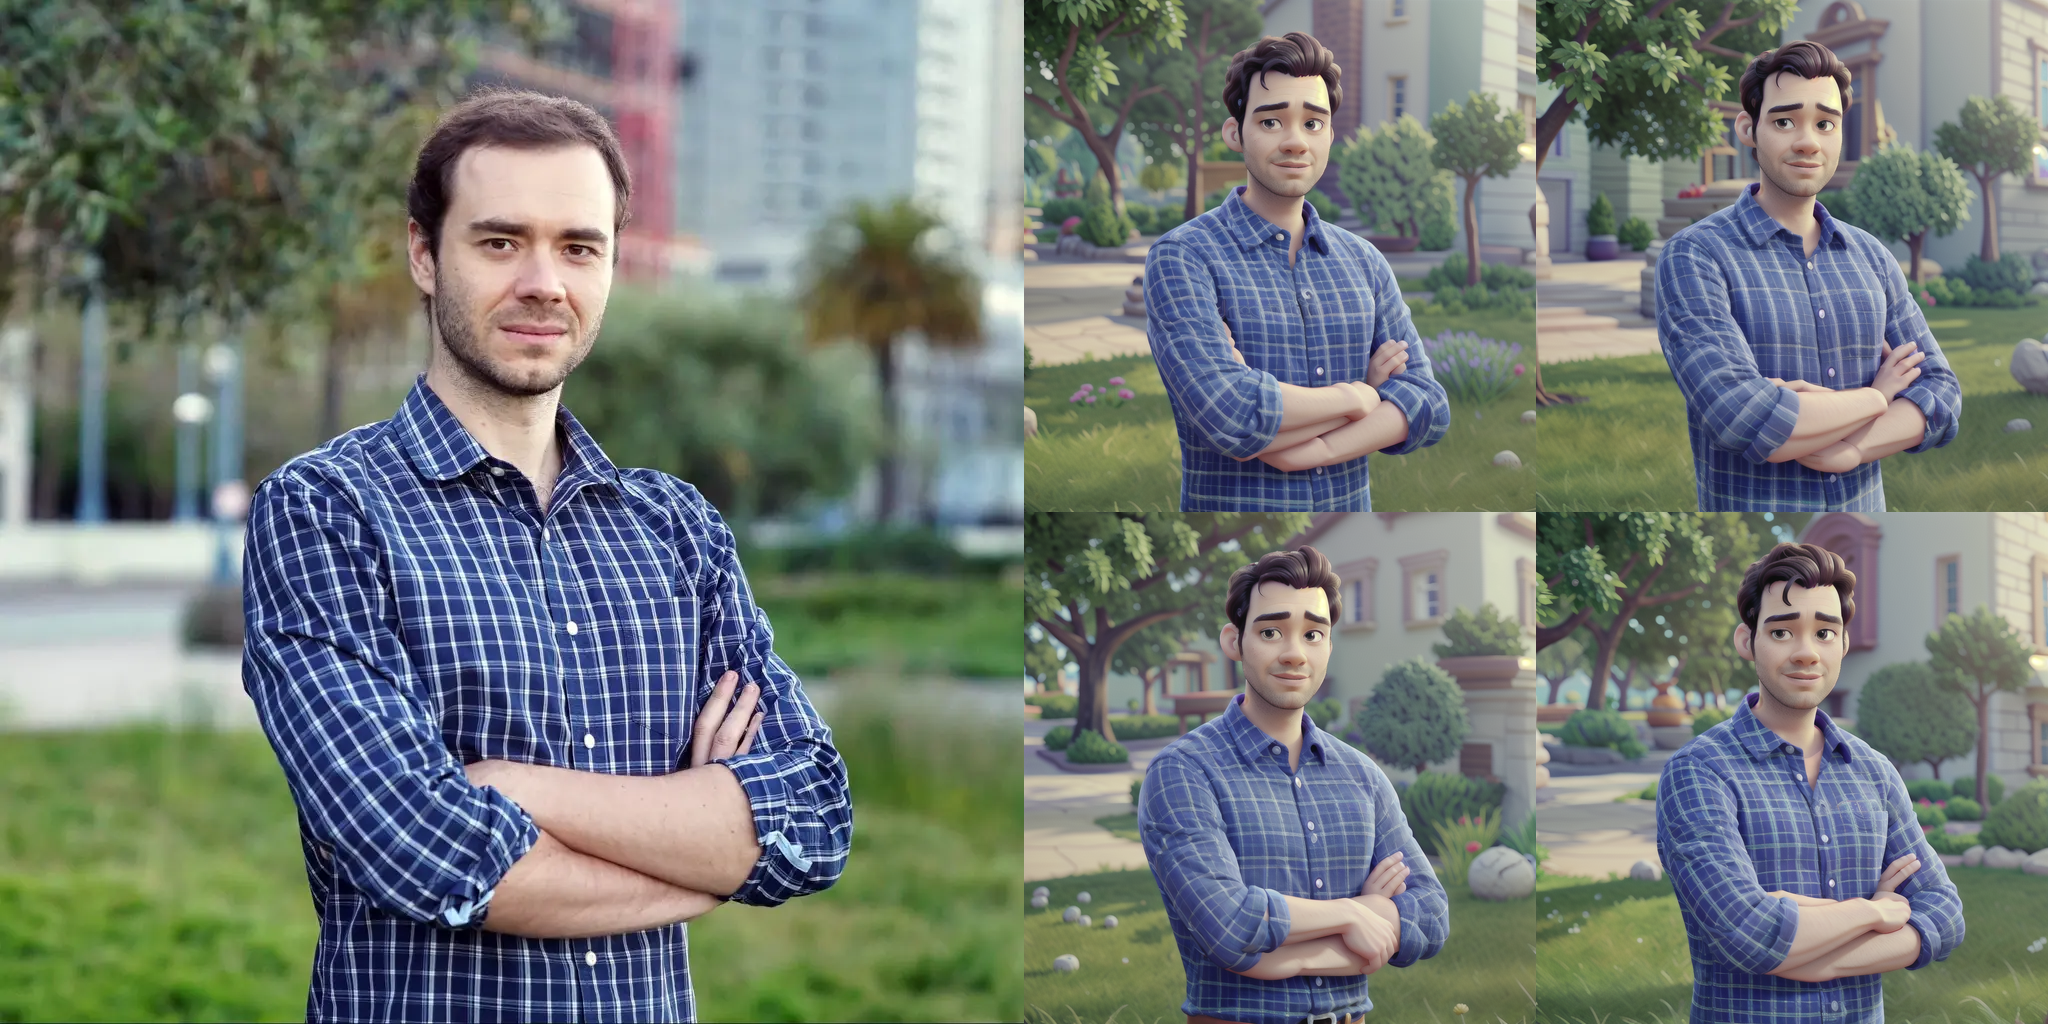

: 

In [6]:
import cv2
from insightface.app import FaceAnalysis
import torch
import numpy as np

import matplotlib.pyplot as plt

app = FaceAnalysis(name="buffalo_l", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

pipeline.enable_lora()

# path_or_url = "../assets/examples/yann-lecun.jpg"
# path_or_url = "../assets/examples/andrew_ng.jpg"
path_or_url = "../assets/examples/andrej_karpathy.webp"
init_image = load_image(path_or_url)

faces = app.get(np.array(init_image))

faceid_embeds = torch.from_numpy(faces[0].normed_embedding).unsqueeze(0)

bbox = faces[0]['bbox']
cropped_image = np.array(init_image)[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
plt.imshow(cropped_image)
plt.show()

prompt = "breathtaking 3D image in the pixar style, disney, cartoon, 4k,unreal engine, blender 8k,outdoor,natural lighting,adult,clear face,stock image"
negative_prompt = "noisy, sloppy, messy, grainy, highly detailed, ultra textured, photo, NSFW"
H, W = 1024, 1024
n_infer_steps = 32
guidance_scale = 10.5
prompt_strength = 0.6
high_noise_frac = 0.8
num_images_per_prompt = 4

ip_adapter_scale = 0.8

pipeline.set_ip_adapter_scale(ip_adapter_scale)

images = pipeline(prompt, 
                 negative_prompt=negative_prompt, 
                 image=init_image, 
                 strength=prompt_strength, 
                 guidance_scale=guidance_scale,
                 num_inference_steps=n_infer_steps,
                 num_images_per_prompt=num_images_per_prompt,
                 target_size = (H, W),
                 ip_adapter_image=cropped_image,
                 clip_skip=1,
                 high_noise_frac=high_noise_frac)

image = create_collage(images.images, init_image.size)

make_image_grid([init_image, image], rows=1, cols=2)